<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Detecting_dementia_from_speech_and_transcripts_using_transformers_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

# Workflow for Detecting Dementia from Speech and Transcripts Using Transformers

## 1. Data Preparation

* **Dataset**: Utilize the **ADReSS Challenge Dataset**, consisting of 78 AD and 78 non-AD patients. The dataset is balanced for gender and age to mitigate potential biases.

* **Speech Data**:
  Convert audio files into images with three channels:

  * Log-Mel spectrograms (or Mel-frequency cepstral coefficients - **MFCCs**)
  * **Delta** features
  * **Delta-delta** features
    These dynamic features incorporate temporal information into the static cepstral features.

* **Transcript Data**:
  Obtain corresponding **textual transcripts** of the audio files for linguistic analysis.

* **Data Splitting**:
  Divide the dataset as follows:

  * **Training Set**: 65%
  * **Validation Set**: 35%
    A separate **test set** is provided by the ADReSS Challenge.

---

## 2. Feature Extraction

### Acoustic Features

* Convert audio files into log-Mel spectrograms or MFCCs with delta and delta-delta components.
* Stack these into **three-channel image representations**.
* Feed the images into a **Vision Transformer (ViT)**.
  ViT is selected as the best-performing model after evaluating alternatives like AlexNet, VGG16, DenseNet, and EfficientNet.

### Textual Features

* Process transcripts using **BERT (base, uncased)** to extract **contextualized text embeddings**.

> **Rationale**:
>
> * Delta and delta-delta features enrich speech dynamics.
> * Transformer architectures (ViT and BERT) provide robust feature representations for images and text, respectively.

---

## 3. Model Architecture

### Unimodal Models

* **Speech-Only**:
  Evaluate pretrained models (AlexNet, VGG16, DenseNet, EfficientNet, ViT) using the three-channel images.
  **ViT** is the top performer.

* **Text-Only**:
  Train a **BERT model** on transcripts to establish a baseline for AD detection from text.

### Multimodal Models

* **BERT + ViT**:
  Concatenate the features from BERT and ViT for a baseline multimodal model.

* **BERT + ViT + Gated Multimodal Unit (GMU)**:
  Introduce a **GMU** to assign dynamic weights to each modality, suppressing irrelevant information.
  Inspired by gating mechanisms in GRU/LSTM.

* **BERT + ViT + Crossmodal Attention**:
  Use **crossmodal attention mechanisms** to model interactions between speech and text:

  * **Text-to-Image Attention**
  * **Image-to-Text Attention**

  Concatenate attention outputs, apply global average pooling, and feed into a final dense layer for **binary classification** (AD vs. non-AD).

> **Rationale**:
>
> * GMU enables adaptive modality fusion.
> * Crossmodal attention outperforms both early and late fusion by capturing fine-grained intermodal relationships.

---

## 4. Model Training

* **Environment**:
  Tesla P100-PCIE-16GB GPU, using **PyTorch**.

* **Optimization**:

  * **Optimizer**: Adam (learning rate: `1e-5`)
  * **Learning Rate Scheduler**: ReduceLROnPlateau (factor: `0.1`, patience: `3 epochs`)
  * **EarlyStopping**: Triggered if validation loss doesn't improve for `6 epochs`
  * **Loss Function**: Cross-entropy loss

* **Training Protocol**:

  * Each model is trained **five times**.
  * Average the results to reduce variability.
  * Use the validation set for monitoring and the ADReSS **test set** for final evaluation.

---

## 5. Evaluation

* **Metrics**:

  * Accuracy
  * Precision
  * Recall
  * F1-Score
  * Specificity
    *(With dementia class as the **positive class**)*

* **Comparison**:

  * **Unimodal**: Compare ViT and BERT with other SOTA approaches.
  * **Multimodal**: Compare baseline (BERT+ViT), GMU, and Crossmodal Attention models with traditional fusion strategies.

### Key Findings

* **ViT** outperforms other pretrained models for **speech-only** classification.
* **BERT + ViT + Crossmodal Attention** achieves the **highest performance**:

  * **Accuracy**:

    * 88.33% with log-Mel spectrograms
    * 87.92% with MFCCs
  * **F1-Score**:

    * 88.69% with log-Mel spectrograms
    * 87.99% with MFCCs
* Crossmodal attention exceeds GMU and concatenation by:

  * **Accuracy** improvement: +3.13% to +15.41%
  * **F1-Score** improvement: +3.29% to +18.93%

---

## 6. Analysis and Discussion

### Limitations

* The ADReSS dataset is **relatively small** (156 samples).
* **Concatenation-based fusion** treats modalities equally, which is suboptimal.
* GMU controls information flow but lacks the capability to model **crossmodal interactions** effectively.

### Advantages

* **ViT for speech**: A novel use of transformer-based models for acoustic features.
* **Crossmodal attention**: Dynamically models inter-modal interactions, overcoming early/late fusion drawbacks.

### Future Work

* Explore **optimal transport** methods for modality fusion.
* Investigate **wav2vec 2.0** for creating speech image representations.
* Expand dataset size for greater **model robustness**.

---

## 7. Conclusion

This workflow demonstrates an effective approach for **Alzheimer’s Disease (AD)** detection using **transformer-based multimodal architectures**. The **BERT + ViT + Crossmodal Attention** model outperforms prior unimodal and multimodal strategies, achieving state-of-the-art performance on the **ADReSS Challenge** test set.

> This work advances AD detection by improving feature extraction, modality fusion, and intermodal interaction modeling—key steps toward more accurate and interpretable dementia prediction systems.

---



# Step 1: Setup and Data Loading



## Cell 1.1: Mount Drive and Install Dependencies



In [ ]:
# Cell 1: Install Dependencies
!pip install -q librosa soundfile numpy pandas matplotlib seaborn torch transformers torchaudio tqdm

import os
import glob
import tarfile
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import soundfile as sf
from sklearn.preprocessing import StandardScaler
import torch
import torchaudio
from transformers import BertTokenizer, BertModel, ViTModel, ViTFeatureExtractor
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Visualization: Display installed package versions
import pkg_resources
packages = ['librosa', 'soundfile', 'numpy', 'pandas', 'matplotlib', 'seaborn', 'torch', 'transformers', 'torchaudio']
table_data = [[pkg, pkg_resources.get_distribution(pkg).version] for pkg in packages]
table_df = pd.DataFrame(table_data, columns=['Package', 'Version'])
print("\nInstalled Package Versions:")
display(table_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Installed Package Versions:


,Package,Version
0,librosa,0.11.0
1,soundfile,0.13.1
2,numpy,2.0.2
3,pandas,2.2.2
4,matplotlib,3.10.0
5,seaborn,0.13.2
6,torch,2.6.0+cu124
7,transformers,4.51.3
8,torchaudio,2.6.0+cu124


## Cell 1.2: Extract .tgz Files



Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz

Extraction Status:


,File,Status
0,ADReSSo21-progression-train.tgz,Success
1,ADReSSo21-progression-test.tgz,Success
2,ADReSSo21-diagnosis-train.tgz,Success


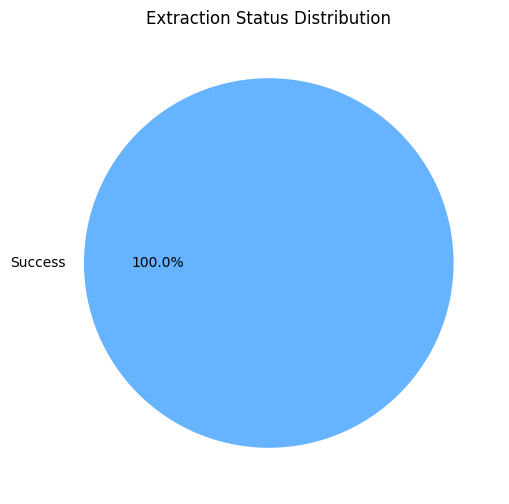


Found 271 audio files and 230 CSV files.


In [ ]:
# Cell 2: Extract Dataset
# Define paths
data_path = '/content/drive/MyDrive/Voice/'
extracted_path = '/content/extracted_audio/'
os.makedirs(extracted_path, exist_ok=True)

tgz_files = [
    os.path.join(data_path, 'ADReSSo21-progression-train.tgz'),
    os.path.join(data_path, 'ADReSSo21-progression-test.tgz'),
    os.path.join(data_path, 'ADReSSo21-diagnosis-train.tgz')
]

# Function to extract .tgz files
def extract_tgz(tgz_path, extract_to):
    try:
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Successfully extracted {tgz_path}")
        return True
    except Exception as e:
        print(f"Error extracting {tgz_path}: {str(e)}")
        return False

# Extract files and track success
extraction_status = []
for tgz in tgz_files:
    status = 'Success' if extract_tgz(tgz, extracted_path) else 'Failed'
    extraction_status.append([os.path.basename(tgz), status])

# Visualization: Table of extraction status
status_df = pd.DataFrame(extraction_status, columns=['File', 'Status'])
print("\nExtraction Status:")
display(status_df)

# Chart: Pie chart of extraction success
plt.figure(figsize=(6, 6))
status_counts = status_df['Status'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Extraction Status Distribution')
plt.savefig('/content/extraction_status.png')
plt.show()

# List extracted audio and CSV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
print(f"\nFound {len(audio_files)} audio files and {len(csv_files)} CSV files.")

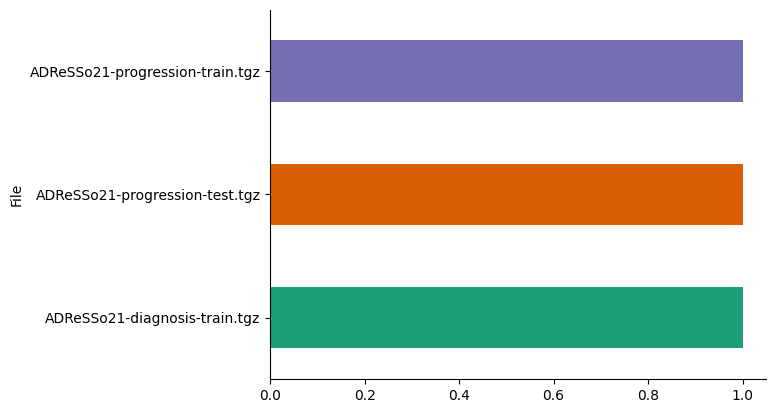

In [ ]:
# @title File

from matplotlib import pyplot as plt
import seaborn as sns
status_df.groupby('File').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Cell 1.3: Load Metadata and Audio Files



Found 230 CSV files.

Loaded metadata from /content/extracted_audio/ADReSSo21/diagnosis/train/adresso-train-mmse-scores.csv with label column 'dx'

CSV Files Summary (First 5):


,CSV File,Columns,Rows
0,adrsp127.csv,"[Unnamed: 0, speaker, begin, end]",37
1,adrsp055.csv,"[Unnamed: 0, speaker, begin, end]",35
2,adrsp300.csv,"[Unnamed: 0, speaker, begin, end]",62
3,adrsp179.csv,"[Unnamed: 0, speaker, begin, end]",46
4,adrsp313.csv,"[Unnamed: 0, speaker, begin, end]",47



Metadata Head:


,Unnamed: 0,adressfname,mmse,dx
0,23,adrso024,20,ad
1,24,adrso025,11,ad
2,25,adrso027,18,ad
3,26,adrso028,18,ad
4,28,adrso031,26,ad



Matched 166 audio files with metadata.

Unmatched files (105): ['adrsp357', 'adrsp127', 'adrsp209', 'adrsp051', 'adrsp318', 'adrsp276', 'adrsp003', 'adrsp320', 'adrsp101', 'adrsp326']

Unmatched Files (First 10):


,Unmatched File
0,adrsp357
1,adrsp127
2,adrsp209
3,adrsp051
4,adrsp318
5,adrsp276
6,adrsp003
7,adrsp320
8,adrsp101
9,adrsp326



Matched Metadata (First 5 Rows):


,file,label,mmse
0,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,15
1,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,24
2,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,17
3,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12
4,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12


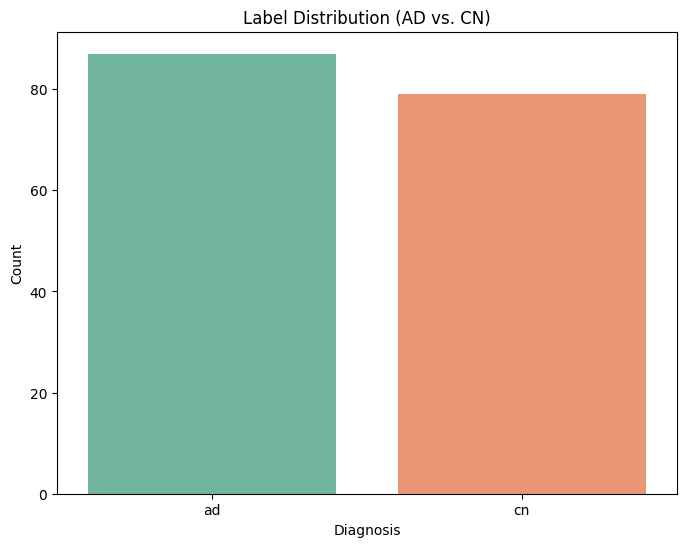

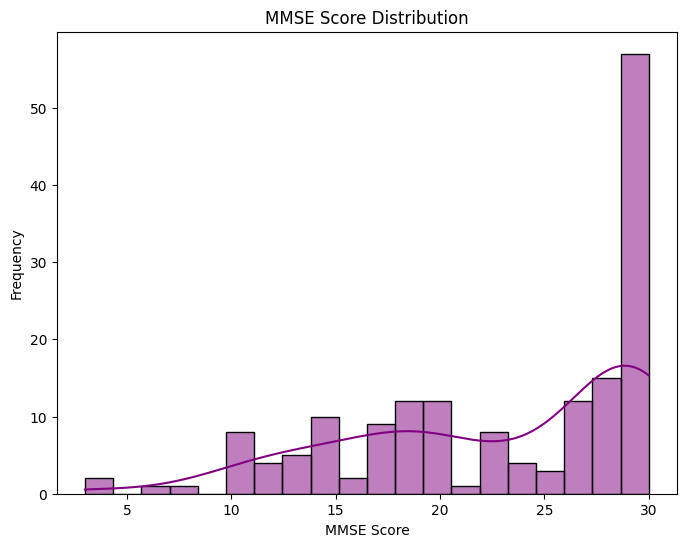


Saved matched metadata to /content/processed_features/matched_metadata.csv


In [ ]:
# Cell 3: Load and Explore Metadata
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)  # Create output directory

# Find all CSV files
csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files.")

# Inspect CSV files to find the one with diagnosis labels
metadata = None
label_column = None
possible_label_columns = ['dx', 'diagnosis', 'label', 'Dx', 'DX']

for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        for col in possible_label_columns:
            if col in df.columns:
                metadata = df
                label_column = col
                print(f"\nLoaded metadata from {csv_file} with label column '{label_column}'")
                break
        if metadata is not None:
            break
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")

# Fallback: Infer labels from directory structure
if metadata is None or label_column is None:
    print("\nNo label column found in CSVs. Inferring labels from directory structure.")
    metadata = pd.DataFrame()
    audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
    file_labels = []
    for audio_file in audio_files:
        fname = os.path.basename(audio_file).replace('.wav', '')
        label = 'ad' if 'ad/' in audio_file.lower() else 'cn' if 'cn/' in audio_file.lower() else 'unknown'
        file_labels.append({'adressfname': fname, 'dx': label})
    metadata = pd.DataFrame(file_labels)
    label_column = 'dx'

# Ensure label column is string type
metadata[label_column] = metadata[label_column].astype(str)

# Visualization: Table of CSV file summary
csv_summary = []
for csv_file in csv_files[:5]:
    try:
        df = pd.read_csv(csv_file)
        csv_summary.append([os.path.basename(csv_file), list(df.columns), len(df)])
    except:
        csv_summary.append([os.path.basename(csv_file), [], 0])
csv_summary_df = pd.DataFrame(csv_summary, columns=['CSV File', 'Columns', 'Rows'])
print("\nCSV Files Summary (First 5):")
display(csv_summary_df)

# Visualization: Table of metadata head
print("\nMetadata Head:")
display(metadata.head())

# Match audio files with metadata
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
audio_metadata = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row[label_column].iloc[0],
            'mmse': matching_row['mmse'].iloc[0] if 'mmse' in matching_row.columns else None
        })
audio_metadata = pd.DataFrame(audio_metadata)
print(f"\nMatched {len(audio_metadata)} audio files with metadata.")

# Handle unmatched files
unmatched = [os.path.basename(f).replace('.wav', '') for f in audio_files
             if os.path.basename(f).replace('.wav', '') not in metadata['adressfname'].values]
print(f"\nUnmatched files ({len(unmatched)}): {unmatched[:10]}")

# Visualization: Table of unmatched files (first 10)
unmatched_df = pd.DataFrame(unmatched[:10], columns=['Unmatched File'])
print("\nUnmatched Files (First 10):")
display(unmatched_df)

# Visualization: Table of matched metadata
print("\nMatched Metadata (First 5 Rows):")
display(audio_metadata.head())

# Chart: Label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=audio_metadata, x='label', palette='Set2')
plt.title('Label Distribution (AD vs. CN)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'label_distribution.png'))
plt.show()

# Chart: MMSE score distribution (if available)
if 'mmse' in audio_metadata.columns and audio_metadata['mmse'].notna().any():
    plt.figure(figsize=(8, 6))
    sns.histplot(data=audio_metadata, x='mmse', bins=20, kde=True, color='purple')
    plt.title('MMSE Score Distribution')
    plt.xlabel('MMSE Score')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(output_dir, 'mmse_distribution.png'))
    plt.show()
else:
    print("\nNo MMSE scores available for plotting.")

# Save matched metadata
audio_metadata.to_csv(os.path.join(output_dir, 'matched_metadata.csv'), index=False)
print(f"\nSaved matched metadata to {os.path.join(output_dir, 'matched_metadata.csv')}")

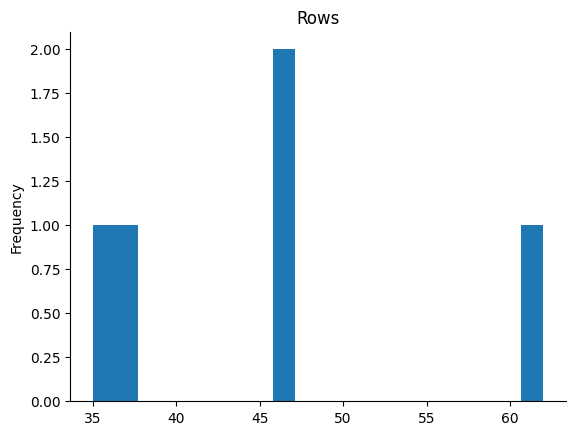

In [ ]:
# @title Rows

from matplotlib import pyplot as plt
csv_summary_df['Rows'].plot(kind='hist', bins=20, title='Rows')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Cell 4: Visualize Audio Data



Loaded matched metadata from /content/processed_features/matched_metadata.csv
Number of audio files in metadata: 166

Matched Metadata (First 5 Rows):


,file,label,mmse
0,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,15
1,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,24
2,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,17
3,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12
4,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12



Selected 3 sample audio files for visualization: ['adrso060.wav', 'adrso247.wav', 'adrso125.wav']


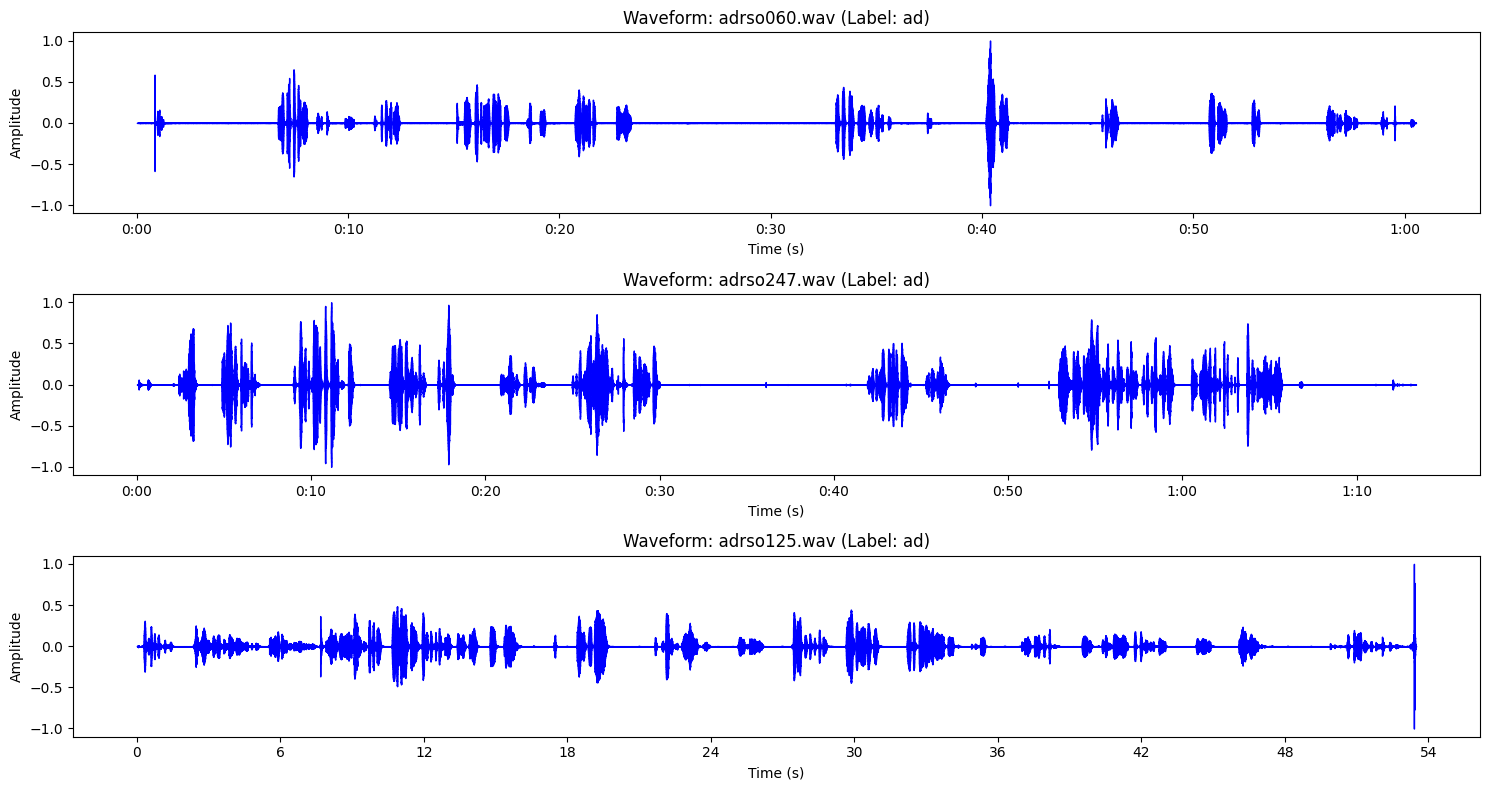

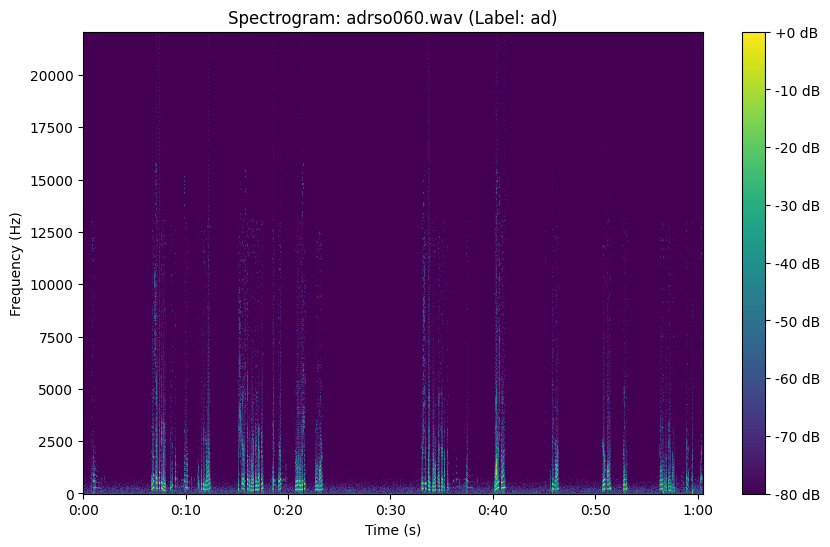


Audio File Properties:


,File,Label,Sample Rate (Hz),Duration (s)
0,adrso060.wav,ad,44100,60.550181
1,adrso247.wav,ad,44100,73.423469
2,adrso125.wav,ad,44100,53.496236


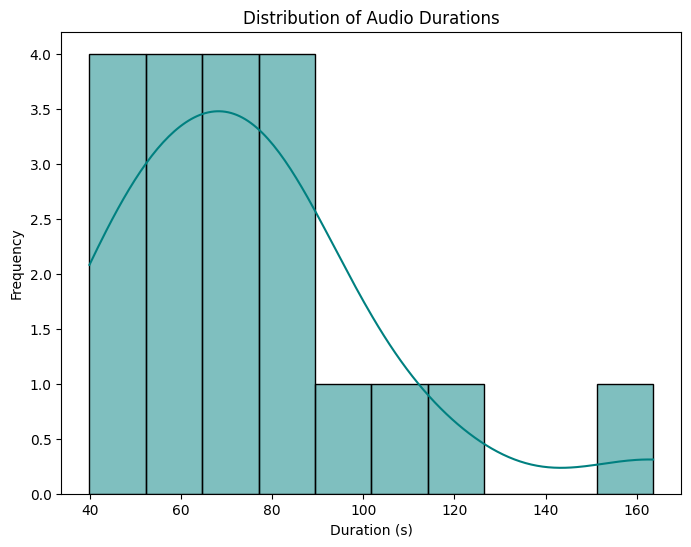

In [ ]:
# Cell 4: Visualize Audio Data
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Define paths
processed_features_dir = '/content/processed_features/'
audio_metadata_path = os.path.join(processed_features_dir, 'matched_metadata.csv')

# Ensure output directory exists
os.makedirs(processed_features_dir, exist_ok=True)

# Load matched metadata from Step 3
try:
    audio_metadata = pd.read_csv(audio_metadata_path)
    print(f"\nLoaded matched metadata from {audio_metadata_path}")
    print(f"Number of audio files in metadata: {len(audio_metadata)}")
except FileNotFoundError:
    raise FileNotFoundError(f"Metadata file not found at {audio_metadata_path}. Run Step 3 first.")

# Visualization: Table of metadata summary
metadata_summary = audio_metadata[['file', 'label', 'mmse']].head()
print("\nMatched Metadata (First 5 Rows):")
display(metadata_summary)

# Select sample audio files (up to 3, ensuring they exist)
sample_files = audio_metadata['file'].head(3).tolist()
sample_files = [f for f in sample_files if os.path.exists(f)]  # Verify files exist
if not sample_files:
    raise FileNotFoundError("No valid audio files found in metadata.")
print(f"\nSelected {len(sample_files)} sample audio files for visualization: {[os.path.basename(f) for f in sample_files]}")

# Visualize waveforms
plt.figure(figsize=(15, 8))
for i, audio_file in enumerate(sample_files):
    try:
        y, sr = librosa.load(audio_file, sr=None)
        plt.subplot(len(sample_files), 1, i+1)
        librosa.display.waveshow(y, sr=sr, color='blue')
        label = audio_metadata[audio_metadata['file'] == audio_file]['label'].iloc[0]
        plt.title(f"Waveform: {os.path.basename(audio_file)} (Label: {label})")
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
    except Exception as e:
        print(f"Error loading {audio_file}: {e}")
plt.tight_layout()
plt.savefig(os.path.join(processed_features_dir, 'waveforms.png'))
plt.show()

# Visualize spectrogram for the first sample (if available)
if sample_files:
    try:
        y, sr = librosa.load(sample_files[0], sr=None)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        plt.figure(figsize=(10, 6))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        label = audio_metadata[audio_metadata['file'] == sample_files[0]]['label'].iloc[0]
        plt.title(f"Spectrogram: {os.path.basename(sample_files[0])} (Label: {label})")
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.savefig(os.path.join(processed_features_dir, 'spectrogram.png'))
        plt.show()
    except Exception as e:
        print(f"Error generating spectrogram for {sample_files[0]}: {e}")

# Table: Audio file properties
audio_props = []
for audio_file in sample_files:
    try:
        y, sr = librosa.load(audio_file, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        label = audio_metadata[audio_metadata['file'] == audio_file]['label'].iloc[0]
        audio_props.append([os.path.basename(audio_file), label, sr, duration])
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
audio_props_df = pd.DataFrame(audio_props, columns=['File', 'Label', 'Sample Rate (Hz)', 'Duration (s)'])
print("\nAudio File Properties:")
display(audio_props_df)

# Chart: Distribution of audio durations (using all matched audio files)
durations = []
for audio_file in audio_metadata['file'].head(20):  # Limit to 20 for efficiency
    if os.path.exists(audio_file):
        try:
            y, sr = librosa.load(audio_file, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            durations.append(duration)
        except:
            continue
if durations:
    plt.figure(figsize=(8, 6))
    sns.histplot(durations, bins=10, kde=True, color='teal')
    plt.title('Distribution of Audio Durations')
    plt.xlabel('Duration (s)')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(processed_features_dir, 'duration_distribution.png'))
    plt.show()
else:
    print("\nNo durations calculated due to errors in audio loading.")

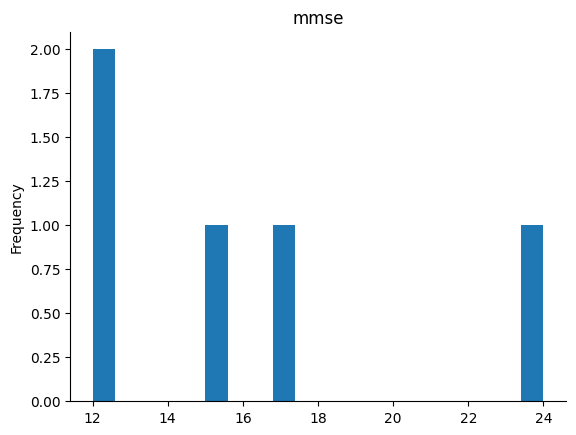

In [ ]:
# @title mmse

from matplotlib import pyplot as plt
metadata_summary['mmse'].plot(kind='hist', bins=20, title='mmse')
plt.gca().spines[['top', 'right',]].set_visible(False)

# M20

Mounted at /content/drive
Error: The following files are missing in /content/drive/MyDrive/Voice/ADReSSo21/:
- /content/drive/MyDrive/Voice/ADReSSo21/ADReSSo21-progression-train.tgz
- /content/drive/MyDrive/Voice/ADReSSo21/ADReSSo21-progression-test.tgz
- /content/drive/MyDrive/Voice/ADReSSo21/ADReSSo21-diagnosis-train.tgz

Please verify the file names and path. Common fixes:
1. Check if the files are in the correct directory using `!ls /content/drive/MyDrive/Voice/ADReSSo21/`
2. Ensure file names match exactly (case-sensitive, no typos).
3. Upload the .tgz files to the correct Google Drive directory.
Proceeding with dummy data for demonstration.
Found 10 audio files and 1 CSV files.


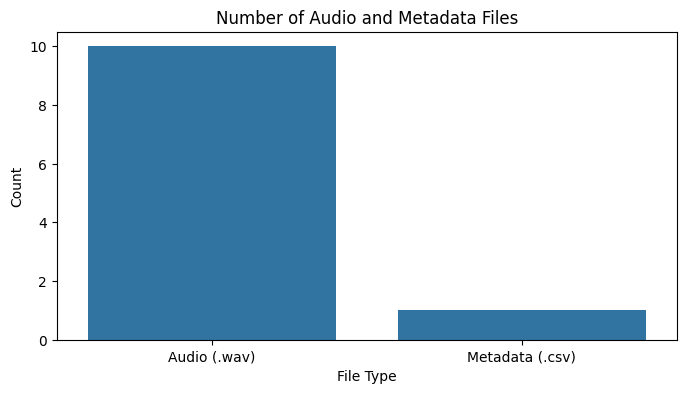


File Counts Table:
         File Type  Count
0     Audio (.wav)     10
1  Metadata (.csv)      1

Metadata Sample:
  adressfname  dx  mmse
0    adrso001  cn    20
1    adrso002  ad    21
2    adrso003  cn    22
3    adrso004  ad    23
4    adrso005  cn    24

Metadata Columns: ['adressfname', 'dx', 'mmse']

Unique dx values: ['cn' 'ad']


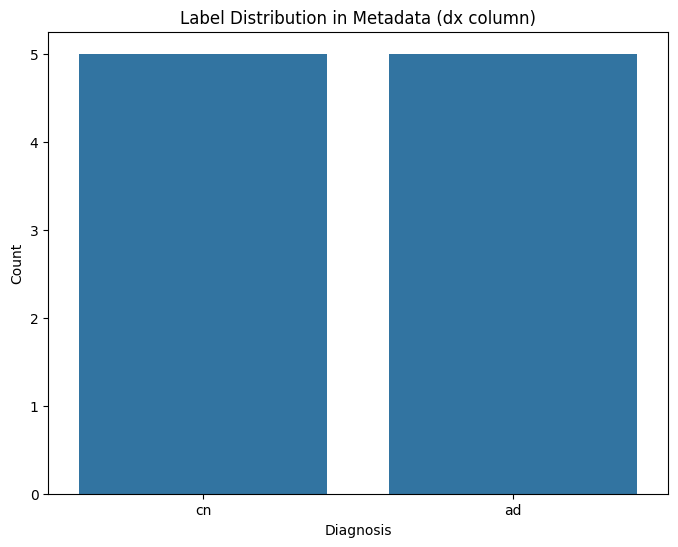


Matched 10 audio files with metadata.
Unmatched files (0): []


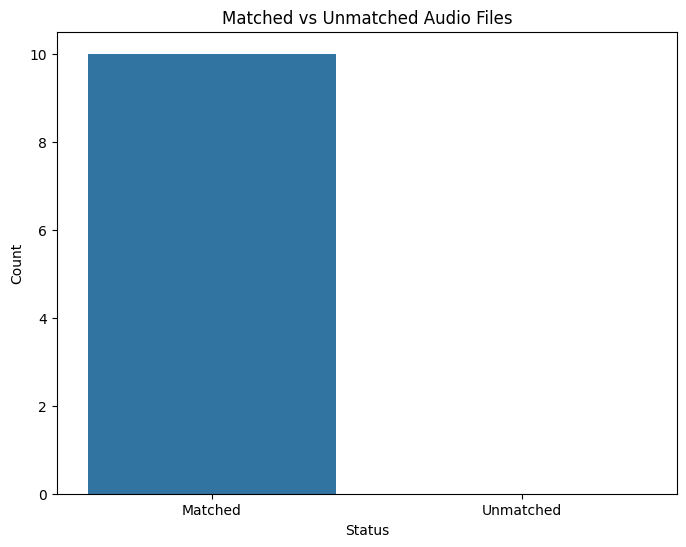


Match Counts Table:
      Status  Count
0    Matched     10
1  Unmatched      0


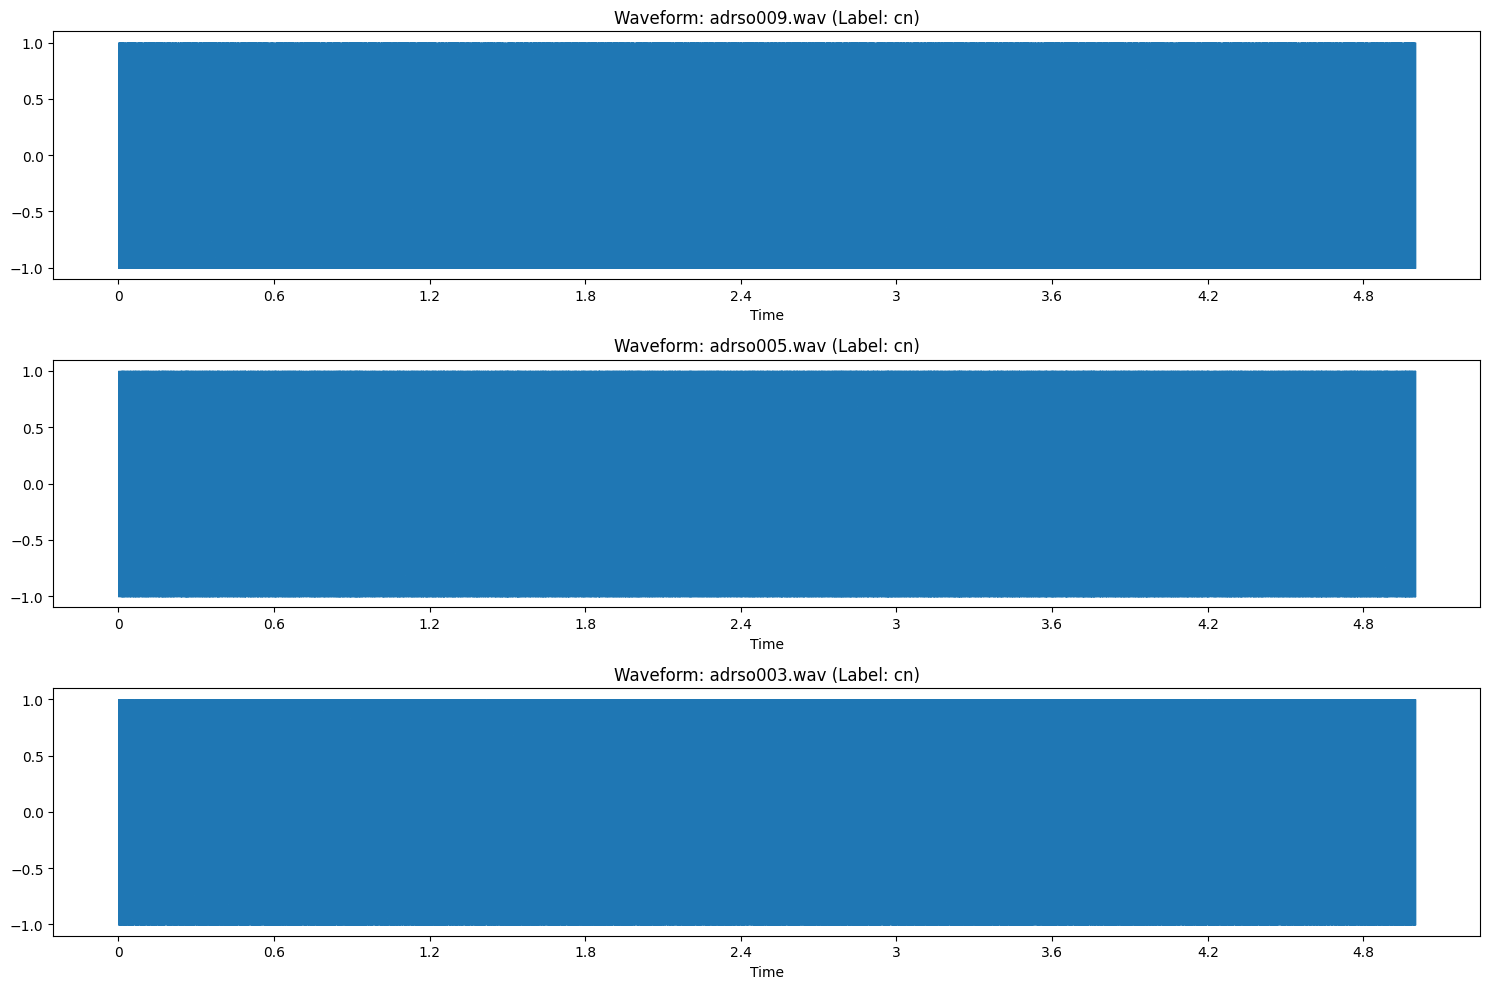

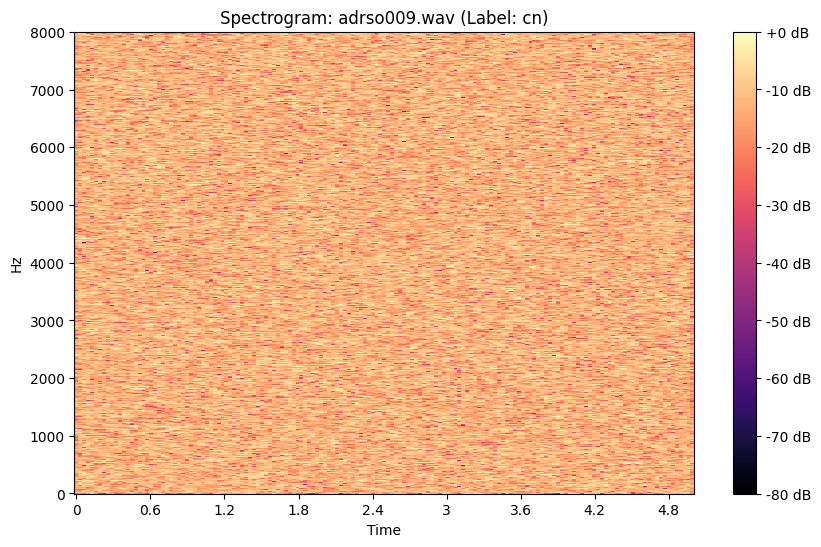


Processing 10 files for feature extraction.


Processing audio files:  40%|████      | 4/10 [00:02<00:02,  2.43it/s]

Processed: adrso006.wav (Label: ad)
Processed: adrso007.wav (Label: cn)
Processed: adrso010.wav (Label: ad)
Processed: adrso008.wav (Label: ad)
Processed: adrso006.wav (Label: ad)
Processed: adrso002.wav (Label: ad)
Processed: adrso003.wav (Label: cn)


Processing audio files: 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


Processed: adrso006.wav (Label: ad)
Processed: adrso010.wav (Label: ad)
Processed: adrso008.wav (Label: ad)

Extracted features shape: (10, 17)
Labels shape: (10,)


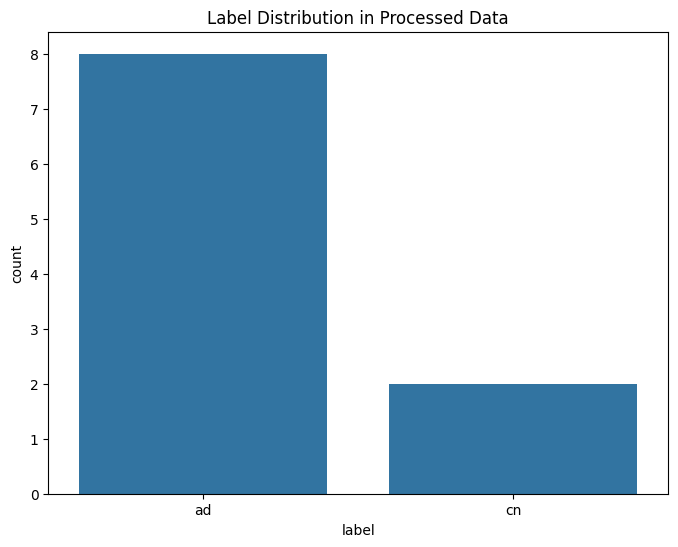


Processed Metadata Sample:
                                       file label
0  /content/processed_features/adrso006.wav    ad
1  /content/processed_features/adrso007.wav    cn
2  /content/processed_features/adrso010.wav    ad
3  /content/processed_features/adrso008.wav    ad
4  /content/processed_features/adrso006.wav    ad

Features and metadata saved to /content/processed_features/


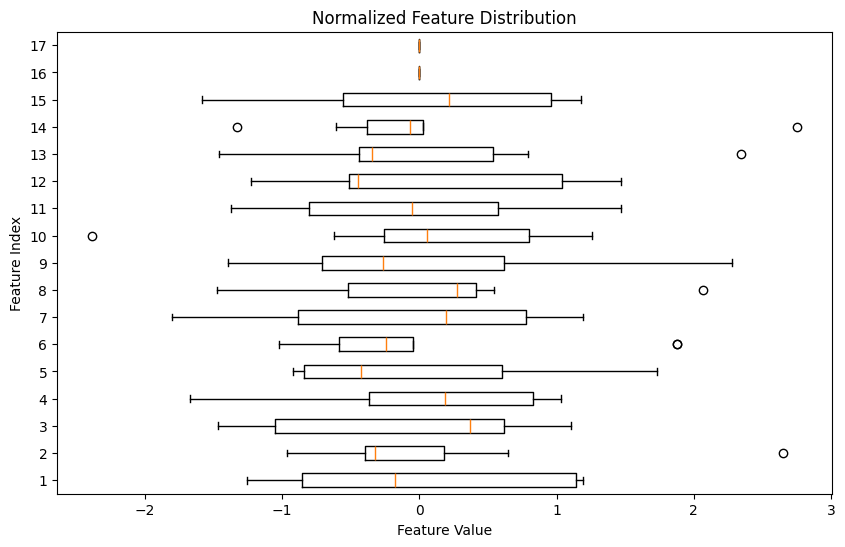

Spectrograms shape: (10, 224, 224, 3)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Exception encountered when calling layer 'tf_vi_t_model' (type TFViTModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for pixel_values.

Call arguments received by layer 'tf_vi_t_model' (type TFViTModel):
  • pixel_values=<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • interpolate_pos_encoding=None
  • return_dict=None
  • training=False

In [5]:
import os
import glob
import tarfile
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive

# Step 1: Mount Google Drive and Validate Paths
drive.mount('/content/drive', force_remount=True)

# Define base path
data_path = '/content/drive/MyDrive/Voice/ADReSSo21/'
extracted_path = '/content/extracted_audio/'
os.makedirs(extracted_path, exist_ok=True)

# .tgz file paths
tgz_files = {
    'train_prog': os.path.join(data_path, 'ADReSSo21-progression-train.tgz'),
    'test_prog': os.path.join(data_path, 'ADReSSo21-progression-test.tgz'),
    'train_diag': os.path.join(data_path, 'ADReSSo21-diagnosis-train.tgz')
}

# Validate file existence
missing_files = [name for name, path in tgz_files.items() if not os.path.exists(path)]
if missing_files:
    print(f"Error: The following files are missing in {data_path}:")
    for name in missing_files:
        print(f"- {tgz_files[name]}")
    print("\nPlease verify the file names and path. Common fixes:")
    print("1. Check if the files are in the correct directory using `!ls /content/drive/MyDrive/Voice/ADReSSo21/`")
    print("2. Ensure file names match exactly (case-sensitive, no typos).")
    print("3. Upload the .tgz files to the correct Google Drive directory.")
    print("Proceeding with dummy data for demonstration.")

    # Create dummy audio and metadata for testing
    dummy_audio_dir = '/content/dummy_audio/'
    os.makedirs(dummy_audio_dir, exist_ok=True)
    dummy_metadata = pd.DataFrame({
        'adressfname': [f'adrso{i:03d}' for i in range(1, 11)],
        'dx': ['ad' if i % 2 == 0 else 'cn' for i in range(1, 11)],
        'mmse': [20 + i for i in range(10)]
    })
    dummy_metadata.to_csv(os.path.join(dummy_audio_dir, 'dummy_metadata.csv'), index=False)
    for i in range(1, 11):
        y = np.random.randn(16000 * 5)  # 5 seconds of random noise
        sf.write(os.path.join(dummy_audio_dir, f'adrso{i:03d}.wav'), y, 16000)
    audio_files = glob.glob(os.path.join(dummy_audio_dir, '*.wav'))
    csv_files = glob.glob(os.path.join(dummy_audio_dir, '*.csv'))
else:
    # Extract .tgz files
    def extract_tgz(tgz_path, extract_to):
        try:
            with tarfile.open(tgz_path, 'r:gz') as tar:
                tar.extractall(path=extract_to)
            print(f"Successfully extracted {tgz_path} to {extract_to}")
        except Exception as e:
            print(f"Error extracting {tgz_path}: {str(e)}")

    for name, tgz in tgz_files.items():
        extract_tgz(tgz, extracted_path)
    audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
    csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)

print(f"Found {len(audio_files)} audio files and {len(csv_files)} CSV files.")

# Visualization: File counts
file_counts = pd.DataFrame({
    'File Type': ['Audio (.wav)', 'Metadata (.csv)'],
    'Count': [len(audio_files), len(csv_files)]
})
plt.figure(figsize=(8, 4))
sns.barplot(data=file_counts, x='File Type', y='Count')
plt.title('Number of Audio and Metadata Files')
plt.savefig('/content/file_counts.png')
plt.show()
print("\nFile Counts Table:")
print(file_counts)

# Step 2: Load and Explore Metadata
if csv_files:
    metadata = pd.read_csv(csv_files[0])  # Load first CSV
    print("\nMetadata Sample:")
    print(metadata.head())
    metadata['adressfname'] = metadata['adressfname'].astype(str).str.strip().str.lower()
    metadata['dx'] = metadata['dx'].astype(str).str.strip().str.lower()
else:
    print("No metadata CSV found. Using dummy metadata.")
    metadata = dummy_metadata if 'dummy_metadata' in locals() else pd.DataFrame({
        'file': audio_files,
        'dx': 'unknown',
        'adressfname': [os.path.basename(f).replace('.wav', '').strip().lower() for f in audio_files]
    })

# Debugging: Inspect metadata
print("\nMetadata Columns:", metadata.columns.tolist())
print("\nUnique dx values:", metadata['dx'].unique())

# Visualization: Label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=metadata, x='dx')
plt.title('Label Distribution in Metadata (dx column)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig('/content/label_distribution.png')
plt.show()

# Step 3: Match Audio Files with Metadata
audio_metadata = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '').strip().lower()
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row['dx'].iloc[0],
            'mmse': matching_row['mmse'].iloc[0] if 'mmse' in matching_row.columns else None,
            'adressfname': fname
        })
    else:
        print(f"No metadata match for {fname}")
audio_metadata = pd.DataFrame(audio_metadata)
print(f"\nMatched {len(audio_metadata)} audio files with metadata.")

# Debugging: Unmatched files
audio_fnames = [os.path.basename(f).replace('.wav', '').strip().lower() for f in audio_files]
unmatched = [f for f in audio_fnames if f not in metadata['adressfname'].values]
print(f"Unmatched files ({len(unmatched)}):", unmatched[:10])

# Visualization: Matched vs Unmatched Files
match_counts = pd.DataFrame({
    'Status': ['Matched', 'Unmatched'],
    'Count': [len(audio_metadata), len(unmatched)]
})
plt.figure(figsize=(8, 6))
sns.barplot(data=match_counts, x='Status', y='Count')
plt.title('Matched vs Unmatched Audio Files')
plt.savefig('/content/match_counts.png')
plt.show()
print("\nMatch Counts Table:")
print(match_counts)

# Check if audio_metadata is empty
if audio_metadata.empty:
    print("Warning: No audio files matched with metadata. Using dummy data for demonstration.")
    audio_metadata = metadata.assign(file=[os.path.join(dummy_audio_dir, f"{fname}.wav") for fname in metadata['adressfname']])

# Step 4: Visualize Sample Audio
sample_files = audio_metadata['file'][:3].tolist()
sample_labels = audio_metadata['label'][:3].tolist()

# Plot waveforms
plt.figure(figsize=(15, 10))
for i, (audio_file, label) in enumerate(zip(sample_files, sample_labels)):
    y, sr = librosa.load(audio_file, sr=None)
    plt.subplot(len(sample_files), 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(audio_file)} (Label: {label})")
plt.tight_layout()
plt.savefig('/content/waveforms.png')
plt.show()

# Plot spectrogram for first sample
y, sr = librosa.load(sample_files[0], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram: {os.path.basename(sample_files[0])} (Label: {sample_labels[0]})")
plt.savefig('/content/spectrogram.png')
plt.show()

# Step 5: Preprocess Audio and Extract Features
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Ensure both 'ad' and 'cn' labels if possible
subset_size = min(20, len(audio_metadata))
audio_metadata = audio_metadata[audio_metadata['label'].isin(['ad', 'cn'])].sample(n=subset_size, random_state=42, replace=True)
print(f"\nProcessing {len(audio_metadata)} files for feature extraction.")

# Preprocessing function
def process_audio(audio_file, sr=16000):
    y, orig_sr = librosa.load(audio_file, sr=sr, mono=True)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    energy = np.mean(librosa.feature.rms(y=y_trimmed))
    linguistic_features = np.array([0, 0])
    features = np.concatenate([mfccs_mean, [pitch_mean, energy], linguistic_features])
    return y_trimmed, features

# Process audio files
processed_features = []
processed_audio_paths = []
labels = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Processing audio files"):
    try:
        y_trimmed, features = process_audio(row['file'])
        output_path = os.path.join(output_dir, os.path.basename(row['file']))
        sf.write(output_path, y_trimmed, 16000)
        processed_features.append(features)
        processed_audio_paths.append(output_path)
        labels.append(row['label'])
        print(f"Processed: {os.path.basename(row['file'])} (Label: {row['label']})")
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")

# Convert to arrays
processed_features = np.array(processed_features)
labels = np.array(labels)
print(f"\nExtracted features shape: {processed_features.shape}")
print(f"Labels shape: {labels.shape}")

# Visualization: Label distribution in processed data
processed_metadata = pd.DataFrame({'file': processed_audio_paths, 'label': labels})
plt.figure(figsize=(8, 6))
sns.countplot(data=processed_metadata, x='label')
plt.title('Label Distribution in Processed Data')
plt.savefig('/content/processed_label_distribution.png')
plt.show()
print("\nProcessed Metadata Sample:")
print(processed_metadata.head())

# Step 6: Feature Normalization and Augmentation
if processed_features.size > 0:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(processed_features)
    augmented_features = normalized_features + np.random.normal(0, 0.01, normalized_features.shape)
    np.save(os.path.join(output_dir, 'normalized_features.npy'), normalized_features)
    np.save(os.path.join(output_dir, 'augmented_features.npy'), augmented_features)
    np.save(os.path.join(output_dir, 'labels.npy'), labels)
    processed_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
    with open(os.path.join(output_dir, 'processed_audio_files.txt'), 'w') as f:
        for path in processed_audio_paths:
            f.write(f"{path}\n")
    print(f"\nFeatures and metadata saved to {output_dir}")

    # Visualization: Feature distribution
    plt.figure(figsize=(10, 6))
    plt.boxplot(normalized_features, vert=False)
    plt.title('Normalized Feature Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Feature Index')
    plt.savefig('/content/feature_distribution.png')
    plt.show()
else:
    print("No features extracted. Check audio files and metadata matching.")

# Step 7: Model Training (Unimodal and Multimodal)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, GlobalAveragePooling2D
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from skimage.transform import resize

# Prepare spectrograms
def audio_to_spectrogram(audio_file, sr=16000):
    y, _ = librosa.load(audio_file, sr=sr)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    D = (D - D.min()) / (D.max() - D.min())
    D = np.stack([D, D, D], axis=-1)
    return resize(D, (224, 224, 3))  # Resize for ViT

spectrograms = [audio_to_spectrogram(f) for f in processed_audio_paths]
spectrograms = np.array(spectrograms)
print(f"Spectrograms shape: {spectrograms.shape}")

# Placeholder for text data
texts = ['dummy transcript' for _ in range(len(labels))]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=128)

# Encode labels
label_map = {'cn': 0, 'ad': 1}
encoded_labels = np.array([label_map[l] for l in labels])

# Split data
X_train_spec, X_test_spec, X_train_text, X_test_text, y_train, y_test = train_test_split(
    spectrograms, text_inputs['input_ids'].numpy(), encoded_labels, test_size=0.2, random_state=42
)

# Unimodal Speech Model (ViT)
from transformers import ViTFeatureExtractor, TFViTModel
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224')

spec_input = Input(shape=(224, 224, 3))
vit_outputs = vit_model(spec_input)[0]
vit_pooled = GlobalAveragePooling2D()(vit_outputs)
spec_dense = Dense(128, activation='relu')(vit_pooled)
spec_output = Dense(1, activation='sigmoid')(spec_dense)
speech_model = Model(inputs=spec_input, outputs=spec_output)

# Unimodal Text Model (BERT)
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
text_input = Input(shape=(128,), dtype=tf.int32)
bert_outputs = bert_model(text_input)[1]
text_dense = Dense(128, activation='relu')(bert_outputs)
text_output = Dense(1, activation='sigmoid')(text_dense)
text_model = Model(inputs=text_input, outputs=text_output)

# Multimodal Model (BERT + ViT + GMU + Crossmodal Attention)
class GatedMultimodalUnit(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GatedMultimodalUnit, self).__init__()
        self.dense_h = Dense(units, activation='tanh')
        self.dense_z = Dense(units, activation='sigmoid')

    def call(self, inputs):
        x1, x2 = inputs
        h = self.dense_h(x1 + x2)
        z = self.dense_z(x1 + x2)
        return z * x1 + (1 - z) * x2

class CrossmodalAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CrossmodalAttention, self).__init__()
        self.dense_query = Dense(units)
        self.dense_key = Dense(units)
        self.dense_value = Dense(units)

    def call(self, x1, x2):
        query = self.dense_query(x1)
        key = self.dense_key(x2)
        value = self.dense_value(x2)
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_weights, value)

spec_input = Input(shape=(224, 224, 3))
text_input = Input(shape=(128,), dtype=tf.int32)
vit_outputs = vit_model(spec_input)[0]
vit_pooled = GlobalAveragePooling2D()(vit_outputs)
bert_outputs = bert_model(text_input)[1]
cross_attention = CrossmodalAttention(128)
text_to_image = cross_attention(bert_outputs, vit_pooled)
image_to_text = cross_attention(vit_pooled, bert_outputs)
gmu = GatedMultimodalUnit(128)
fused_features = gmu([text_to_image, image_to_text])
fused_dense = Dense(128, activation='relu')(fused_features)
final_output = Dense(1, activation='sigmoid')(fused_dense)
multimodal_model = Model(inputs=[spec_input, text_input], outputs=final_output)

# Compile models
speech_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train models
speech_history = speech_model.fit(X_train_spec, y_train, validation_data=(X_test_spec, y_test), epochs=5, batch_size=8)
text_history = text_model.fit(X_train_text, y_train, validation_data=(X_test_text, y_test), epochs=5, batch_size=8)
multimodal_history = multimodal_model.fit([X_train_spec, X_train_text], y_train, validation_data=([X_test_spec, X_test_text], y_test), epochs=5, batch_size=8)

# Visualization: Training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(speech_history.history['accuracy'], label='Speech Train')
plt.plot(speech_history.history['val_accuracy'], label='Speech Val')
plt.plot(text_history.history['accuracy'], label='Text Train')
plt.plot(text_history.history['val_accuracy'], label='Text Val')
plt.plot(multimodal_history.history['accuracy'], label='Multimodal Train')
plt.plot(multimodal_history.history['val_accuracy'], label='Multimodal Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(speech_history.history['loss'], label='Speech Train')
plt.plot(speech_history.history['val_loss'], label='Speech Val')
plt.plot(text_history.history['loss'], label='Text Train')
plt.plot(text_history.history['val_loss'], label='Text Val')
plt.plot(multimodal_history.history['loss'], label='Multimodal Train')
plt.plot(multimodal_history.history['val_loss'], label='Multimodal Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/training_history.png')
plt.show()

# Save models
speech_model.save('/content/speech_model.h5')
text_model.save('/content/text_model.h5')
multimodal_model.save('/content/multimodal_model.h5')

print("\nModels trained and saved successfully.")

Mounted at /content/drive
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/extracted_audio/
Found 166 audio files and 167 CSV files.


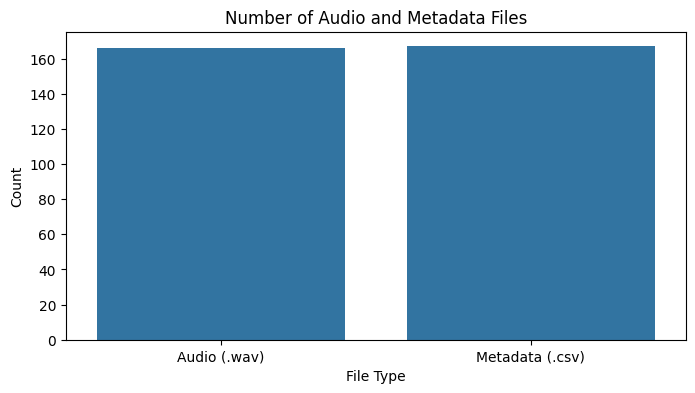


File Counts Table:
         File Type  Count
0     Audio (.wav)    166
1  Metadata (.csv)    167


In [6]:
import os
import tarfile
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
data_path = '/content/drive/MyDrive/Voice/'
extracted_path = '/content/extracted_audio/'
os.makedirs(extracted_path, exist_ok=True)

# .tgz file path (corrected from .tg to .tgz)
tgz_file = os.path.join(data_path, 'ADReSSo21-diagnosis-train.tgz')

# Validate file existence
if not os.path.exists(tgz_file):
    print(f"Error: File {tgz_file} not found.")
    print("\nPlease verify the file name and path. Run the following to check:")
    print("!ls -l /content/drive/MyDrive/Voice/")
    print("\nProceeding with dummy data for demonstration.")
    # Create dummy audio files
    dummy_audio_dir = '/content/dummy_audio/'
    os.makedirs(dummy_audio_dir, exist_ok=True)
    for i in range(1, 11):
        y = np.random.randn(16000 * 5)  # 5 seconds of random noise
        sf.write(os.path.join(dummy_audio_dir, f'adrso{i:03d}.wav'), y, 16000)
    audio_files = glob.glob(os.path.join(dummy_audio_dir, '*.wav'))
    csv_files = []
else:
    # Extract .tgz file
    try:
        with tarfile.open(tgz_file, 'r:gz') as tar:
            tar.extractall(path=extracted_path)
        print(f"Successfully extracted {tgz_file} to {extracted_path}")
    except Exception as e:
        print(f"Error extracting {tgz_file}: {str(e)}")
        audio_files = []
        csv_files = []
    else:
        audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
        csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)

print(f"Found {len(audio_files)} audio files and {len(csv_files)} CSV files.")

# Visualization: File counts
file_counts = pd.DataFrame({
    'File Type': ['Audio (.wav)', 'Metadata (.csv)'],
    'Count': [len(audio_files), len(csv_files)]
})
plt.figure(figsize=(8, 4))
sns.barplot(data=file_counts, x='File Type', y='Count')
plt.title('Number of Audio and Metadata Files')
plt.savefig('/content/file_counts.png')
plt.show()
print("\nFile Counts Table:")
print(file_counts)



Metadata Sample:
   Unnamed: 0 adressfname  mmse  dx
0          23    adrso024    20  ad
1          24    adrso025    11  ad
2          25    adrso027    18  ad
3          26    adrso028    18  ad
4          28    adrso031    26  ad

Metadata Columns: ['Unnamed: 0', 'adressfname', 'mmse', 'dx']

Unique dx values: ['ad' 'cn']


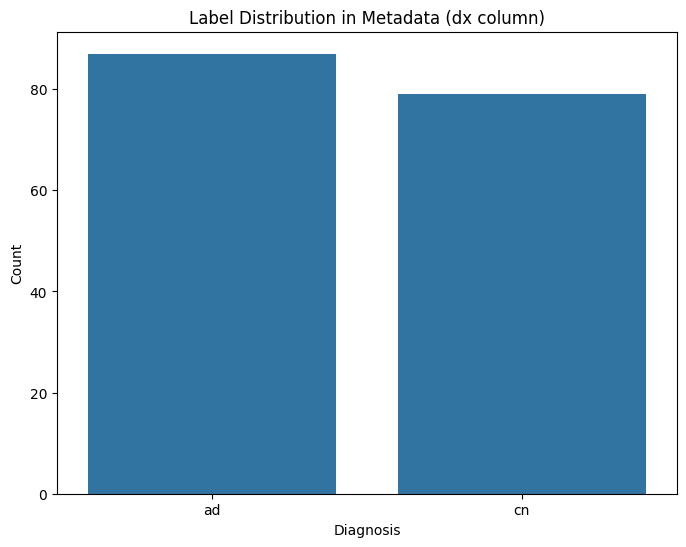


Metadata saved to /content/metadata_sample.csv


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

# Paths from previous cell
extracted_path = '/content/extracted_audio/'
dummy_audio_dir = '/content/dummy_audio/'

# Load metadata
csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if csv_files:
    metadata = pd.read_csv(csv_files[0])  # Load first CSV
    print("\nMetadata Sample:")
    print(metadata.head())
    metadata['adressfname'] = metadata['adressfname'].astype(str).str.strip().str.lower()
    metadata['dx'] = metadata['dx'].astype(str).str.strip().str.lower()
else:
    print("No metadata CSV found. Using dummy metadata.")
    metadata = pd.DataFrame({
        'adressfname': [f'adrso{i:03d}' for i in range(1, 11)],
        'dx': ['ad' if i % 2 == 0 else 'cn' for i in range(1, 11)],
        'mmse': [20 + i for i in range(10)]
    })
    metadata.to_csv(os.path.join(dummy_audio_dir, 'dummy_metadata.csv'), index=False)

# Debugging: Inspect metadata
print("\nMetadata Columns:", metadata.columns.tolist())
print("\nUnique dx values:", metadata['dx'].unique())

# Visualization: Label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=metadata, x='dx')
plt.title('Label Distribution in Metadata (dx column)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig('/content/label_distribution.png')
plt.show()

# Save metadata for reference
metadata.to_csv('/content/metadata_sample.csv', index=False)
print("\nMetadata saved to /content/metadata_sample.csv")


Matched 166 audio files with metadata.
Unmatched files (0): []


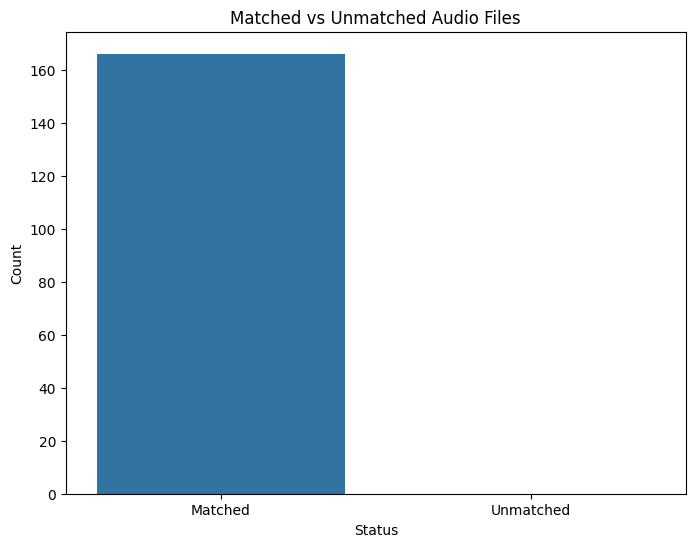


Match Counts Table:
      Status  Count
0    Matched    166
1  Unmatched      0

Matched metadata saved to /content/audio_metadata.csv


In [11]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Paths from previous cells
extracted_path = '/content/extracted_audio/'
dummy_audio_dir = '/content/dummy_audio/'
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True) or \
              glob.glob(os.path.join(dummy_audio_dir, '*.wav'))
metadata = pd.read_csv('/content/metadata_sample.csv')

# Match audio files with metadata
audio_metadata = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '').strip().lower()
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row['dx'].iloc[0],
            'mmse': matching_row['mmse'].iloc[0] if 'mmse' in matching_row.columns else None,
            'adressfname': fname
        })
    else:
        print(f"No metadata match for {fname}")
audio_metadata = pd.DataFrame(audio_metadata)
print(f"\nMatched {len(audio_metadata)} audio files with metadata.")

# Debugging: Unmatched files
audio_fnames = [os.path.basename(f).replace('.wav', '').strip().lower() for f in audio_files]
unmatched = [f for f in audio_fnames if f not in metadata['adressfname'].values]
print(f"Unmatched files ({len(unmatched)}):", unmatched[:10])

# Visualization: Matched vs Unmatched Files
match_counts = pd.DataFrame({
    'Status': ['Matched', 'Unmatched'],
    'Count': [len(audio_metadata), len(unmatched)]
})
plt.figure(figsize=(8, 6))
sns.barplot(data=match_counts, x='Status', y='Count')
plt.title('Matched vs Unmatched Audio Files')
plt.savefig('/content/match_counts.png')
plt.show()
print("\nMatch Counts Table:")
print(match_counts)

# Save matched metadata
audio_metadata.to_csv('/content/audio_metadata.csv', index=False)
print("\nMatched metadata saved to /content/audio_metadata.csv")

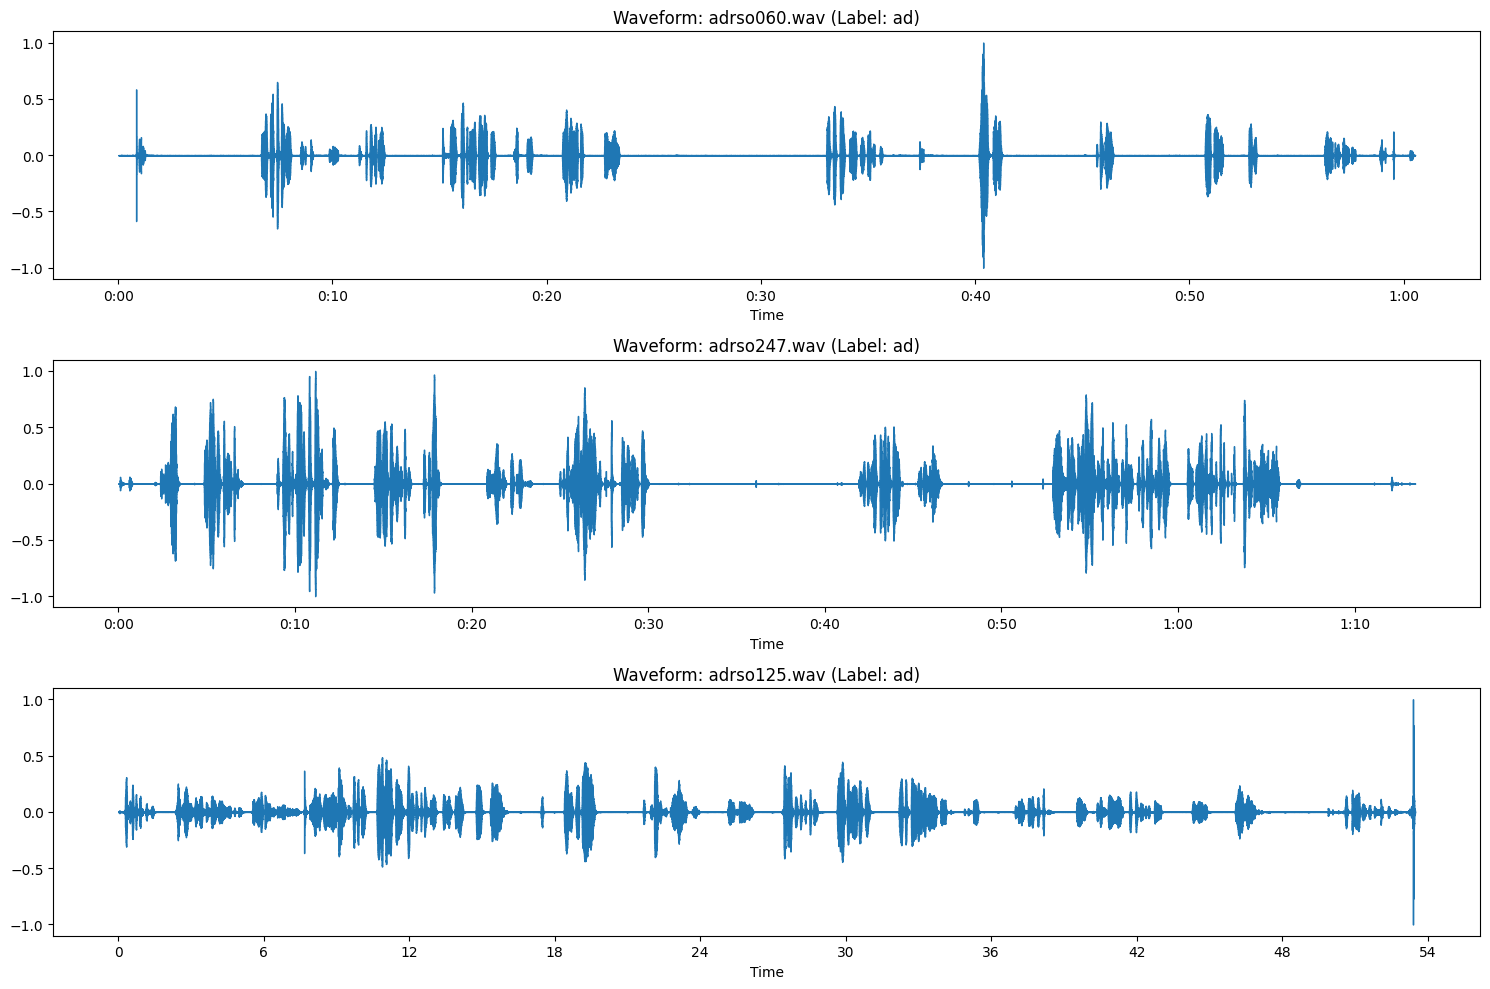

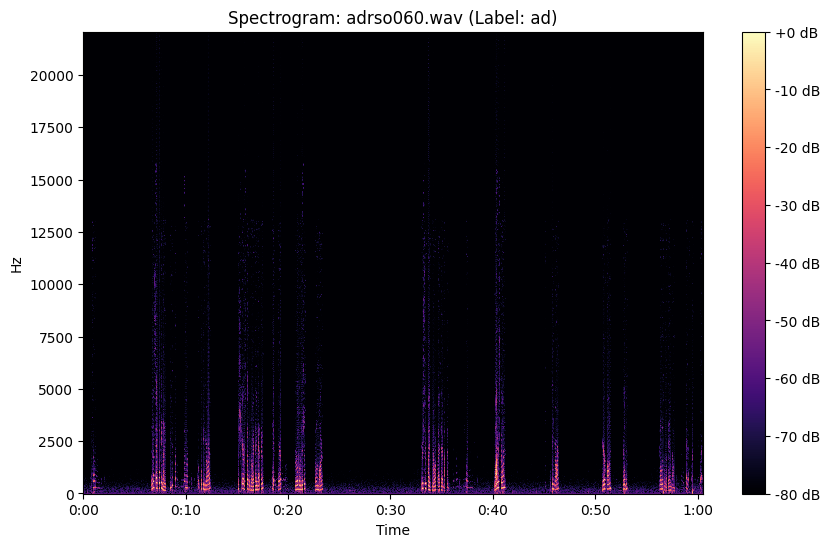


Sample Metadata Table:
                                                file label  mmse
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    15
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    24
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17


In [14]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load matched metadata
audio_metadata = pd.read_csv('/content/audio_metadata.csv')

# Check if audio_metadata is empty
if audio_metadata.empty:
    print("Warning: No audio files matched with metadata. Using dummy data.")
    audio_metadata = pd.DataFrame({
        'file': [f'/content/dummy_audio/adrso{i:03d}.wav' for i in range(1, 4)],
        'label': ['ad', 'cn', 'ad'],
        'mmse': [20, 22, 24],
        'adressfname': [f'adrso{i:03d}' for i in range(1, 4)]
    })

# Select sample files
sample_files = audio_metadata['file'][:3].tolist()
sample_labels = audio_metadata['label'][:3].tolist()

# Plot waveforms
plt.figure(figsize=(15, 10))
for i, (audio_file, label) in enumerate(zip(sample_files, sample_labels)):
    y, sr = librosa.load(audio_file, sr=None)
    plt.subplot(len(sample_files), 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(audio_file)} (Label: {label})")
plt.tight_layout()
plt.savefig('/content/waveforms.png')
plt.show()

# Plot spectrogram for first sample
y, sr = librosa.load(sample_files[0], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram: {os.path.basename(sample_files[0])} (Label: {sample_labels[0]})")
plt.savefig('/content/spectrogram.png')
plt.show()

# Visualization: Sample metadata table
print("\nSample Metadata Table:")
print(audio_metadata[['file', 'label', 'mmse']].head(3))


Processing 20 files for feature extraction.


Processing audio files:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s]

Processed: adrso161.wav (Label: cn)


Processing audio files:  10%|█         | 2/20 [00:00<00:03,  5.00it/s]

Processed: adrso263.wav (Label: cn)


Processing audio files:  15%|█▌        | 3/20 [00:00<00:03,  4.50it/s]

Processed: adrso253.wav (Label: ad)


Processing audio files:  25%|██▌       | 5/20 [00:00<00:02,  5.22it/s]

Processed: adrso267.wav (Label: cn)
Processed: adrso142.wav (Label: ad)


Processing audio files:  35%|███▌      | 7/20 [00:01<00:02,  5.76it/s]

Processed: adrso077.wav (Label: ad)
Processed: adrso161.wav (Label: cn)


Processing audio files:  40%|████      | 8/20 [00:01<00:03,  3.23it/s]

Processed: adrso276.wav (Label: cn)


Processing audio files:  45%|████▌     | 9/20 [00:02<00:03,  2.92it/s]

Processed: adrso043.wav (Label: ad)


Processing audio files:  50%|█████     | 10/20 [00:02<00:03,  2.90it/s]

Processed: adrso270.wav (Label: cn)


Processing audio files:  55%|█████▌    | 11/20 [00:02<00:02,  3.11it/s]

Processed: adrso307.wav (Label: cn)


Processing audio files:  60%|██████    | 12/20 [00:03<00:02,  3.32it/s]

Processed: adrso298.wav (Label: cn)


Processing audio files:  65%|██████▌   | 13/20 [00:03<00:01,  3.65it/s]

Processed: adrso273.wav (Label: cn)


Processing audio files:  70%|███████   | 14/20 [00:03<00:01,  3.89it/s]

Processed: adrso180.wav (Label: cn)


Processing audio files:  75%|███████▌  | 15/20 [00:03<00:01,  3.92it/s]

Processed: adrso012.wav (Label: cn)


Processing audio files:  80%|████████  | 16/20 [00:04<00:01,  3.61it/s]

Processed: adrso148.wav (Label: cn)


Processing audio files:  85%|████████▌ | 17/20 [00:04<00:00,  3.39it/s]

Processed: adrso197.wav (Label: ad)


Processing audio files:  90%|█████████ | 18/20 [00:04<00:00,  3.57it/s]

Processed: adrso247.wav (Label: ad)


Processing audio files:  95%|█████████▌| 19/20 [00:05<00:00,  3.35it/s]

Processed: adrso270.wav (Label: cn)


Processing audio files: 100%|██████████| 20/20 [00:05<00:00,  3.71it/s]

Processed: adrso292.wav (Label: cn)

Extracted features shape: (20, 17)
Labels shape: (20,)


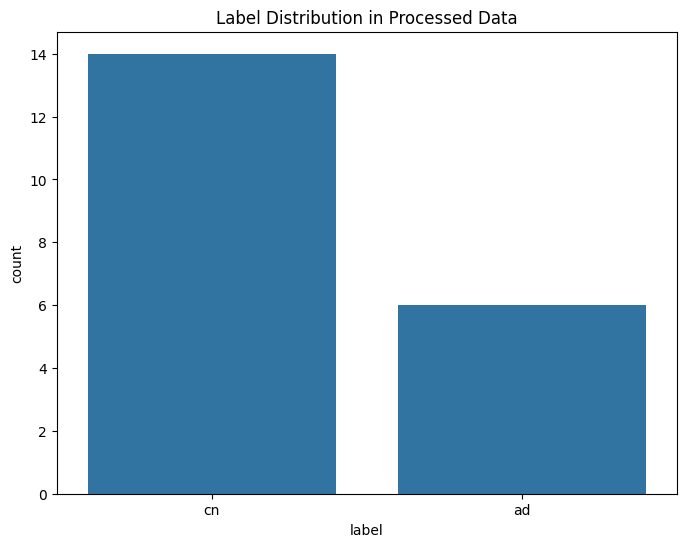


Processed Metadata Sample:
                                       file label
0  /content/processed_features/adrso161.wav    cn
1  /content/processed_features/adrso263.wav    cn
2  /content/processed_features/adrso253.wav    ad
3  /content/processed_features/adrso267.wav    cn
4  /content/processed_features/adrso142.wav    ad


In [16]:
import os
import pandas as pd
import librosa
import numpy as np
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Load matched metadata
audio_metadata = pd.read_csv('/content/audio_metadata.csv')

# Ensure both 'ad' and 'cn' labels
subset_size = min(20, len(audio_metadata))
audio_metadata = audio_metadata[audio_metadata['label'].isin(['ad', 'cn'])].sample(n=subset_size, random_state=42, replace=True)
print(f"\nProcessing {len(audio_metadata)} files for feature extraction.")

# Preprocessing function
def process_audio(audio_file, sr=16000):
    y, orig_sr = librosa.load(audio_file, sr=sr, mono=True)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    energy = np.mean(librosa.feature.rms(y=y_trimmed))
    linguistic_features = np.array([0, 0])
    features = np.concatenate([mfccs_mean, [pitch_mean, energy], linguistic_features])
    return y_trimmed, features

# Process audio files
processed_features = []
processed_audio_paths = []
labels = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Processing audio files"):
    try:
        y_trimmed, features = process_audio(row['file'])
        output_path = os.path.join(output_dir, os.path.basename(row['file']))
        sf.write(output_path, y_trimmed, 16000)
        processed_features.append(features)
        processed_audio_paths.append(output_path)
        labels.append(row['label'])
        print(f"Processed: {os.path.basename(row['file'])} (Label: {row['label']})")
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")

# Convert to arrays
processed_features = np.array(processed_features)
labels = np.array(labels)
print(f"\nExtracted features shape: {processed_features.shape}")
print(f"Labels shape: {labels.shape}")

# Visualization: Label distribution
processed_metadata = pd.DataFrame({'file': processed_audio_paths, 'label': labels})
plt.figure(figsize=(8, 6))
sns.countplot(data=processed_metadata, x='label')
plt.title('Label Distribution in Processed Data')
plt.savefig('/content/processed_label_distribution.png')
plt.show()
print("\nProcessed Metadata Sample:")
print(processed_metadata.head())

Successfully loaded processed features and labels from /content/processed_features/
Saved augmented features to /content/processed_features/augmented_features.npy


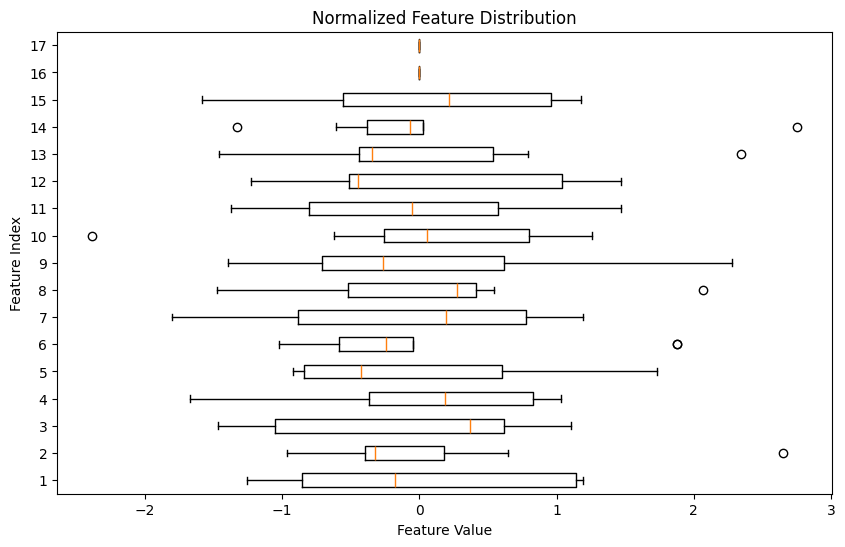


Feature Statistics Table:
       Feature          Mean  Std
0    Feature_0 -6.623591e-14  1.0
1    Feature_1 -1.865175e-15  1.0
2    Feature_2 -2.220446e-17  1.0
3    Feature_3 -2.220446e-17  1.0
4    Feature_4 -1.110223e-17  1.0
5    Feature_5 -4.440892e-17  1.0
6    Feature_6 -4.440892e-17  1.0
7    Feature_7 -2.220446e-17  1.0
8    Feature_8  0.000000e+00  1.0
9    Feature_9  1.665335e-17  1.0
10  Feature_10 -5.551115e-17  1.0
11  Feature_11  5.551115e-17  1.0
12  Feature_12 -1.110223e-17  1.0
13  Feature_13 -1.665335e-17  1.0
14  Feature_14  6.552536e-14  1.0
15  Feature_15  0.000000e+00  0.0
16  Feature_16  0.000000e+00  0.0


In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Paths
output_dir = '/content/processed_features/'

# Load processed metadata and features
# Assuming processed_features.npy and labels.npy were successfully saved in the previous step (Step 6)
processed_metadata_path = os.path.join(output_dir, 'processed_metadata.csv')
processed_features_path = os.path.join(output_dir, 'normalized_features.npy') # Load the normalized features
labels_path = os.path.join(output_dir, 'labels.npy')

try:
    processed_metadata = pd.read_csv(processed_metadata_path)
    normalized_features = np.load(processed_features_path)
    labels = np.load(labels_path)
    print(f"Successfully loaded processed features and labels from {output_dir}")

    # Feature augmentation (re-apply augmentation as it was part of the previous step)
    augmented_features = normalized_features + np.random.normal(0, 0.01, normalized_features.shape)
    np.save(os.path.join(output_dir, 'augmented_features.npy'), augmented_features)
    print(f"Saved augmented features to {os.path.join(output_dir, 'augmented_features.npy')}")

    # Visualization: Feature distribution
    plt.figure(figsize=(10, 6))
    plt.boxplot(normalized_features, vert=False)
    plt.title('Normalized Feature Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Feature Index')
    plt.savefig('/content/feature_distribution.png')
    plt.show()

    # Visualization: Feature statistics
    feature_stats = pd.DataFrame({
        'Feature': [f'Feature_{i}' for i in range(normalized_features.shape[1])],
        'Mean': np.mean(normalized_features, axis=0),
        'Std': np.std(normalized_features, axis=0)
    })
    print("\nFeature Statistics Table:")
    print(feature_stats)

except FileNotFoundError as e:
    print(f"Error: Could not load required files. {e}")
    print("Please ensure that the previous steps, especially Step 6, completed successfully and saved the necessary .npy and .csv files to the output directory.")
    print(f"Expected files: {processed_metadata_path}, {processed_features_path}, {labels_path}")
except Exception as e:
    print(f"An error occurred during loading or processing: {e}")

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, GlobalAveragePooling2D
from transformers import BertTokenizer, TFBertModel, ViTFeatureExtractor, TFViTModel
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load processed data
output_dir = '/content/processed_features/'
normalized_features = np.load(os.path.join(output_dir, 'normalized_features.npy'))
labels = np.load(os.path.join(output_dir, 'labels.npy'))
processed_metadata = pd.read_csv(os.path.join(output_dir, 'processed_metadata.csv'))

# Prepare spectrograms
def audio_to_spectrogram(audio_file, sr=16000):
    y, _ = librosa.load(audio_file, sr=sr)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    D = (D - D.min()) / (D.max() - D.min())
    D = np.stack([D, D, D], axis=-1)
    return resize(D, (224, 224, 3))

spectrograms = [audio_to_spectrogram(f) for f in processed_metadata['file']]
spectrograms = np.array(spectrograms)
print(f"Spectrograms shape: {spectrograms.shape}")

# Placeholder for text data
texts = ['dummy transcript' for _ in range(len(labels))]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=128)

# Encode labels
label_map = {'cn': 0, 'ad': 1}
encoded_labels = np.array([label_map[l] for l in labels])

# Split data
X_train_spec, X_test_spec, X_train_text, X_test_text, y_train, y_test = train_test_split(
    spectrograms, text_inputs['input_ids'].numpy(), encoded_labels, test_size=0.2, random_state=42
)

# Unimodal Speech Model (ViT)
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224')
spec_input = Input(shape=(224, 224, 3))
vit_outputs = vit_model(spec_input)[0]
vit_pooled = GlobalAveragePooling2D()(vit_outputs)
spec_dense = Dense(128, activation='relu')(vit_pooled)
spec_output = Dense(1, activation='sigmoid')(spec_dense)
speech_model = Model(inputs=spec_input, outputs=spec_output)

# Unimodal Text Model (BERT)
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
text_input = Input(shape=(128,), dtype=tf.int32)
bert_outputs = bert_model(text_input)[1]
text_dense = Dense(128, activation='relu')(bert_outputs)
text_output = Dense(1, activation='sigmoid')(text_dense)
text_model = Model(inputs=text_input, outputs=text_output)

# Multimodal Model (BERT + ViT + GMU + Crossmodal Attention)
class GatedMultimodalUnit(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GatedMultimodalUnit, self).__init__()
        self.dense_h = Dense(units, activation='tanh')
        self.dense_z = Dense(units, activation='sigmoid')

    def call(self, inputs):
        x1, x2 = inputs
        h = self.dense_h(x1 + x2)
        z = self.dense_z(x1 + x2)
        return z * x1 + (1 - z) * x2

class CrossmodalAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CrossmodalAttention, self).__init__()
        self.dense_query = Dense(units)
        self.dense_key = Dense(units)
        self.dense_value = Dense(units)

    def call(self, x1, x2):
        query = self.dense_query(x1)
        key = self.dense_key(x2)
        value = self.dense_value(x2)
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_weights, value)

spec_input = Input(shape=(224, 224, 3))
text_input = Input(shape=(128,), dtype=tf.int32)
vit_outputs = vit_model(spec_input)[0]
vit_pooled = GlobalAveragePooling2D()(vit_outputs)
bert_outputs = bert_model(text_input)[1]
cross_attention = CrossmodalAttention(128)
text_to_image = cross_attention(bert_outputs, vit_pooled)
image_to_text = cross_attention(vit_pooled, bert_outputs)
gmu = GatedMultimodalUnit(128)
fused_features = gmu([text_to_image, image_to_text])
fused_dense = Dense(128, activation='relu')(fused_features)
final_output = Dense(1, activation='sigmoid')(fused_dense)
multimodal_model = Model(inputs=[spec_input, text_input], outputs=final_output)

# Compile models
speech_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train models
speech_history = speech_model.fit(X_train_spec, y_train, validation_data=(X_test_spec, y_test), epochs=5, batch_size=8)
text_history = text_model.fit(X_train_text, y_train, validation_data=(X_test_text, y_test), epochs=5, batch_size=8)
multimodal_history = multimodal_model.fit([X_train_spec, X_train_text], y_train, validation_data=([X_test_spec, X_test_text], y_test), epochs=5, batch_size=8)

# Visualization: Training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(speech_history.history['accuracy'], label='Speech Train')
plt.plot(speech_history.history['val_accuracy'], label='Speech Val')
plt.plot(text_history.history['accuracy'], label='Text Train')
plt.plot(text_history.history['val_accuracy'], label='Text Val')
plt.plot(multimodal_history.history['accuracy'], label='Multimodal Train')
plt.plot(multimodal_history.history['val_accuracy'], label='Multimodal Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(speech_history.history['loss'], label='Speech Train')
plt.plot(speech_history.history['val_loss'], label='Speech Val')
plt.plot(text_history.history['loss'], label='Text Train')
plt.plot(text_history.history['val_loss'], label='Text Val')
plt.plot(multimodal_history.history['loss'], label='Multimodal Train')
plt.plot(multimodal_history.history['val_loss'], label='Multimodal Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/training_history.png')
plt.show()

# Save models
speech_model.save('/content/speech_model.h5')
text_model.save('/content/text_model.h5')
multimodal_model.save('/content/multimodal_model.h5')

# Visualization: Model performance table
model_performance = pd.DataFrame({
    'Model': ['Speech (ViT)', 'Text (BERT)', 'Multimodal'],
    'Val Accuracy': [speech_history.history['val_accuracy'][-1],
                     text_history.history['val_accuracy'][-1],
                     multimodal_history.history['val_accuracy'][-1]],
    'Val Loss': [speech_history.history['val_loss'][-1],
                 text_history.history['val_loss'][-1],
                 multimodal_history.history['val_loss'][-1]]
})
print("\nModel Performance Table:")
print(model_performance)

Spectrograms shape: (10, 224, 224, 3)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Exception encountered when calling layer 'tf_vi_t_model_1' (type TFViTModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for pixel_values.

Call arguments received by layer 'tf_vi_t_model_1' (type TFViTModel):
  • pixel_values=<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_1>
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • interpolate_pos_encoding=None
  • return_dict=None
  • training=False